Base directory: C:\Users\hassa\Desktop\Safe_Net\SAFE-NET-AFRICA
Spam path: C:\Users\hassa\Desktop\Safe_Net\SAFE-NET-AFRICA\data\spam.csv
Toxic path: C:\Users\hassa\Desktop\Safe_Net\SAFE-NET-AFRICA\data\train.csv
Original spam columns: ['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
label
0    4825
1     747
Name: count, dtype: int64
Training phishing / spam model...
Done.
Phishing model accuracy: 0.9847533632286996

Classification report (phishing):
              precision    recall  f1-score   support

     ham (0)       0.99      0.99      0.99       966
    spam (1)       0.96      0.93      0.94       149

    accuracy                           0.98      1115
   macro avg       0.97      0.96      0.97      1115
weighted avg       0.98      0.98      0.98      1115

Confusion matrix (phishing):
 [[960   6]
 [ 11 138]]


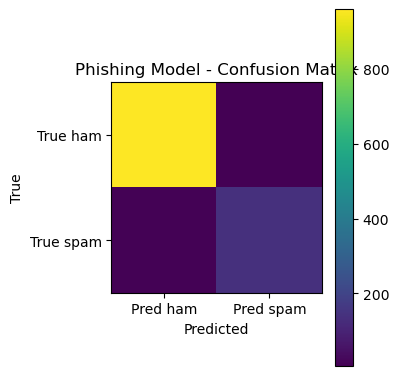

Saved phishing model to: C:\Users\hassa\Desktop\Safe_Net\SAFE-NET-AFRICA\models\phishing_model.joblib
Columns in toxic dataset: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
label
0    143400
1     16171
Name: count, dtype: int64
Downsampled toxicity dataset from 159571 to 150000 rows.
Training toxicity / abuse model...
Done.
Toxicity model accuracy: 0.9445

Classification report (toxicity):
                 precision    recall  f1-score   support

not abusive (0)       0.98      0.96      0.97     26962
    abusive (1)       0.68      0.84      0.75      3038

       accuracy                           0.94     30000
      macro avg       0.83      0.90      0.86     30000
   weighted avg       0.95      0.94      0.95     30000

Confusion matrix (toxicity):
 [[25783  1179]
 [  486  2552]]


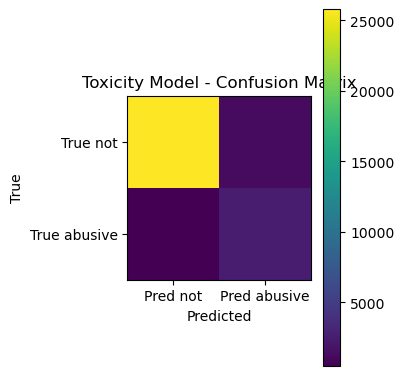

Saved toxicity model to: C:\Users\hassa\Desktop\Safe_Net\SAFE-NET-AFRICA\models\toxicity_model.joblib

Sample phishing predictions:
- 'WINNER!! You have won a $1000 Walmart gift card. Click here ...' -> spam probability: 0.907
- 'Hi, are we still meeting for lunch tomorrow?...' -> spam probability: 0.085

Sample toxicity predictions:
- 'You are a terrible person and nobody likes you....' -> abuse probability: 0.942
- 'Thank you for helping me today, I really appreciate it....' -> abuse probability: 0.022


In [1]:
# %%
# 1. Imports & basic setup

import os
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)

import joblib

# For displaying confusion matrix nicely (optional)
import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# %%
# 2. Paths

BASE_DIR = Path().resolve()
DATA_DIR = BASE_DIR / "data"
MODELS_DIR = BASE_DIR / "models"

SPAM_PATH = DATA_DIR / "spam.csv"
TOXIC_PATH = DATA_DIR / "train.csv"

print("Base directory:", BASE_DIR)
print("Spam path:", SPAM_PATH)
print("Toxic path:", TOXIC_PATH)

MODELS_DIR.mkdir(exist_ok=True, parents=True)

# %%
# 3. Helper: basic text cleaner (similar style to utils.clean_text)

import re

def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.strip()
    text = re.sub(r"\s+", " ", text)
    return text

# %%
# 4. Load & prepare SMS spam / phishing dataset

spam_df = pd.read_csv(SPAM_PATH, encoding="latin-1")

print("Original spam columns:", spam_df.columns.tolist())
spam_df.head()

# %%
# The Kaggle spam dataset often has columns like: v1 (label), v2 (text), and some extra unnamed.
# We handle both common formats.

if {"label", "message"}.issubset(spam_df.columns):
    label_col = "label"
    text_col = "message"
elif {"v1", "v2"}.issubset(spam_df.columns):
    label_col = "v1"
    text_col = "v2"
else:
    raise ValueError(
        "Unexpected column names in spam.csv. "
        "Expected ('label','message') or ('v1','v2'). "
        f"Found: {spam_df.columns.tolist()}"
    )

# Keep only the necessary columns
spam_df = spam_df[[label_col, text_col]].rename(columns={label_col: "label", text_col: "text"})

# Map labels to binary integers: ham -> 0, spam -> 1
spam_df["label"] = spam_df["label"].map({"ham": 0, "spam": 1}).astype(int)

# Clean text
spam_df["text"] = spam_df["text"].astype(str).apply(clean_text)

print(spam_df["label"].value_counts())
spam_df.head()

# %%
# 5. Train/test split for phishing model

X_phish = spam_df["text"]
y_phish = spam_df["label"]

X_train_phish, X_test_phish, y_train_phish, y_test_phish = train_test_split(
    X_phish,
    y_phish,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_phish,
)

len(X_train_phish), len(X_test_phish)

# %%
# 6. Build pipeline for phishing / scam detection

phishing_pipeline = Pipeline(
    steps=[
        (
            "tfidf",
            TfidfVectorizer(
                ngram_range=(1, 2),
                min_df=3,
                max_df=0.9,
            ),
        ),
        (
            "clf",
            LogisticRegression(
                max_iter=200,
                class_weight="balanced",
            ),
        ),
    ]
)

# %%
# 7. Train phishing model

print("Training phishing / spam model...")
phishing_pipeline.fit(X_train_phish, y_train_phish)
print("Done.")

# %%
# 8. Evaluate phishing model

y_pred_phish = phishing_pipeline.predict(X_test_phish)

acc_phish = accuracy_score(y_test_phish, y_pred_phish)
print("Phishing model accuracy:", acc_phish)

print("\nClassification report (phishing):")
print(classification_report(y_test_phish, y_pred_phish, target_names=["ham (0)", "spam (1)"]))

cm_phish = confusion_matrix(y_test_phish, y_pred_phish)
print("Confusion matrix (phishing):\n", cm_phish)

# Optional: visualize confusion matrix
plt.figure(figsize=(4, 4))
plt.imshow(cm_phish, interpolation="nearest")
plt.title("Phishing Model - Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ["Pred ham", "Pred spam"])
plt.yticks([0, 1], ["True ham", "True spam"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# %%
# 9. Save phishing model

phishing_model_path = MODELS_DIR / "phishing_model.joblib"
joblib.dump(phishing_pipeline, phishing_model_path)
print(f"Saved phishing model to: {phishing_model_path}")

# %%
# 10. Load & prepare Jigsaw toxicity dataset

toxic_df = pd.read_csv(TOXIC_PATH)

print("Columns in toxic dataset:", toxic_df.columns.tolist())
toxic_df.head()

# %%
# Jigsaw usually has: comment_text, toxic, severe_toxic, obscene, threat, insult, identity_hate

required_cols = {
    "comment_text",
    "toxic",
    "severe_toxic",
    "obscene",
    "threat",
    "insult",
}

missing = required_cols - set(toxic_df.columns)
if missing:
    raise ValueError(f"Missing expected columns in train.csv: {missing}")

# Create binary abusive label
toxic_df["abusive"] = (
    toxic_df["toxic"]
    + toxic_df["severe_toxic"]
    + toxic_df["obscene"]
    + toxic_df["threat"]
    + toxic_df["insult"]
) > 0

toxic_df["abusive"] = toxic_df["abusive"].astype(int)

# Keep only needed columns
toxic_df = toxic_df[["comment_text", "abusive"]].rename(
    columns={"comment_text": "text", "abusive": "label"}
)

# Clean text
toxic_df["text"] = toxic_df["text"].astype(str).apply(clean_text)

print(toxic_df["label"].value_counts())
toxic_df.head()

# %%
# 11. (Optional) Downsample for speed if dataset is large

MAX_ROWS = 150_000  # adjust if needed

if len(toxic_df) > MAX_ROWS:
    toxic_df_small = toxic_df.sample(n=MAX_ROWS, random_state=RANDOM_STATE)
    print(f"Downsampled toxicity dataset from {len(toxic_df)} to {len(toxic_df_small)} rows.")
else:
    toxic_df_small = toxic_df
    print(f"Using full toxicity dataset: {len(toxic_df_small)} rows.")

# %%
# 12. Train/test split for toxicity model

X_tox = toxic_df_small["text"]
y_tox = toxic_df_small["label"]

X_train_tox, X_test_tox, y_train_tox, y_test_tox = train_test_split(
    X_tox,
    y_tox,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_tox,
)

len(X_train_tox), len(X_test_tox)

# %%
# 13. Build pipeline for toxicity / abuse detection

toxicity_pipeline = Pipeline(
    steps=[
        (
            "tfidf",
            TfidfVectorizer(
                ngram_range=(1, 2),
                min_df=3,
                max_df=0.9,
            ),
        ),
        (
            "clf",
            LogisticRegression(
                max_iter=200,
                class_weight="balanced",
            ),
        ),
    ]
)

# %%
# 14. Train toxicity model

print("Training toxicity / abuse model...")
toxicity_pipeline.fit(X_train_tox, y_train_tox)
print("Done.")

# %%
# 15. Evaluate toxicity model

y_pred_tox = toxicity_pipeline.predict(X_test_tox)

acc_tox = accuracy_score(y_test_tox, y_pred_tox)
print("Toxicity model accuracy:", acc_tox)

print("\nClassification report (toxicity):")
print(classification_report(y_test_tox, y_pred_tox, target_names=["not abusive (0)", "abusive (1)"]))

cm_tox = confusion_matrix(y_test_tox, y_pred_tox)
print("Confusion matrix (toxicity):\n", cm_tox)

# Optional: visualize confusion matrix
plt.figure(figsize=(4, 4))
plt.imshow(cm_tox, interpolation="nearest")
plt.title("Toxicity Model - Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ["Pred not", "Pred abusive"])
plt.yticks([0, 1], ["True not", "True abusive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# %%
# 16. Save toxicity model

toxicity_model_path = MODELS_DIR / "toxicity_model.joblib"
joblib.dump(toxicity_pipeline, toxicity_model_path)
print(f"Saved toxicity model to: {toxicity_model_path}")

# %%
# 17. Quick sanity checks on a few sample texts

sample_spam = [
    "WINNER!! You have won a $1000 Walmart gift card. Click here to claim now.",
    "Hi, are we still meeting for lunch tomorrow?",
]

print("\nSample phishing predictions:")
for msg in sample_spam:
    prob = phishing_pipeline.predict_proba([clean_text(msg)])[0][1]
    print(f"- '{msg[:60]}...' -> spam probability: {prob:.3f}")

sample_toxic = [
    "You are a terrible person and nobody likes you.",
    "Thank you for helping me today, I really appreciate it.",
]

print("\nSample toxicity predictions:")
for msg in sample_toxic:
    prob = toxicity_pipeline.predict_proba([clean_text(msg)])[0][1]
    print(f"- '{msg[:60]}...' -> abuse probability: {prob:.3f}")
